In [ ]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np


#### Load and Inspect Data

In [4]:
print("--- Step 1: Loading and Inspecting Data ---")
try:

    df = pd.read_csv("/kaggle/input/online-retail-ll-csv/online_retail_II.csv")
except FileNotFoundError:
    print("Error: online_retail_II.csv not found. Please download it from Kaggle and place it in the correct directory.")
    print("Dataset link: https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci")
    exit()
print("Original DataFrame Head:")
print(df.head())
print("\nDataFrame Info:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())

--- Step 1: Loading and Inspecting Data ---
Original DataFrame Head:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column    

In [9]:
df.info

<bound method DataFrame.info of         Invoice StockCode                          Description  Quantity  \
0        489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1        489434    79323P                   PINK CHERRY LIGHTS        12   
2        489434    79323W                  WHITE CHERRY LIGHTS        12   
3        489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4        489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...         ...       ...                                  ...       ...   
1067366  581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
1067367  581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
1067368  581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
1067369  581587     22138        BAKING SET 9 PIECE RETROSPOT          3   
1067370  581587      POST                              POSTAGE         1   

                 InvoiceDate  Price  Customer ID       

In [8]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


#### Data Cleaning and Preprocessing

In [5]:

print("\n--- Step 2. Data Cleaning and Preprocessing ---")

df.dropna(subset=['Customer ID'], inplace=True)

df['Customer ID'] = df['Customer ID'].astype(int)

df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print("\nCleaned DataFrame Head:")
print(df.head(3))
print("DataFrame shape after cleaning:", df.shape)



--- Step 2. Data Cleaning and Preprocessing ---

Cleaned DataFrame Head:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95        13085  United Kingdom  
1 2009-12-01 07:45:00   6.75        13085  United Kingdom  
2 2009-12-01 07:45:00   6.75        13085  United Kingdom  
DataFrame shape after cleaning: (805549, 8)


In [11]:
df['InvoiceDate'].dt.month

0          12
1          12
2          12
3          12
4          12
           ..
1067366    12
1067367    12
1067368    12
1067369    12
1067370    12
Name: InvoiceDate, Length: 805549, dtype: int32

#### Calculating RFM Metrices

In [12]:
print("\n---Step 3: Calculating RFM Metrics---")
df['TotalPrice'] = df['Quantity'] * df['Price']

snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
print(f"Snapshot Date for recency calculation: {snapshot_date}")



---Step 3: Calculating RFM Metrics---
Snapshot Date for recency calculation: 2011-12-10 12:50:00


#### Group by CustomerID to calculate RFM values


RFM DataFrame Head:
   Customer ID  Recency  Frequency  Monetary
0        12346      326         12  77556.46
1        12347        2          8   5633.32
2        12348       75          5   2019.40
3        12349       19          4   4428.69
4        12350      310          1    334.40

RFM DataFrame Description:
        Customer ID      Recency    Frequency       Monetary
count   5878.000000  5878.000000  5878.000000    5878.000000
mean   15315.313542   201.331916     6.289384    3018.616737
std     1715.572666   209.338707    13.009406   14737.731040
min    12346.000000     1.000000     1.000000       2.950000
25%    13833.250000    26.000000     1.000000     348.762500
50%    15314.500000    96.000000     3.000000     898.915000
75%    16797.750000   380.000000     7.000000    2307.090000
max    18287.000000   739.000000   398.000000  608821.650000


Text(0.5, 1.0, 'Recency Distribution')

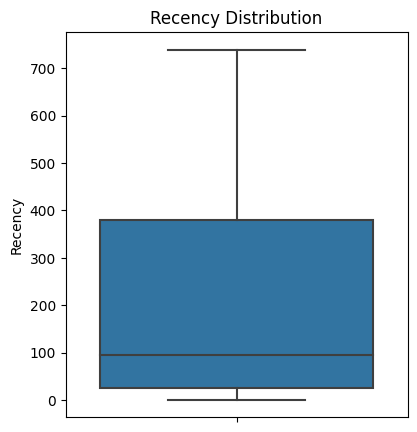

In [14]:
rfm_df=df.groupby('Customer ID').agg(Recency=('InvoiceDate',lambda date:(snapshot_date-date.max()).days),Frequency=('Invoice','nunique'),Monetary=('TotalPrice','sum')).reset_index()
print("\nRFM DataFrame Head:")
print(rfm_df.head())
print("\nRFM DataFrame Description:")
print(rfm_df.describe())

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.boxplot(y=rfm_df['Recency'])
plt.title('Recency Distribution')